In [1]:
# import and dataset loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure

dataset = pd.read_csv("example_dataset.csv")


In [2]:
#ElMo embeddings
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
# Load pre trained ELMo model
elmo = hub.Module("https://tfhub.dev/google/elmo/3")
embedded = elmo(dataset['no_dots'], signature="default", as_dict=True)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
embeddings = sess.run(embedded['default'])

2023-04-19 18:46:15.788715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 18:46:15.896018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-19 18:46:15.896032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-19 18:46:15.911911: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-19 18:46:16.324544: W tensorflow/stream_executor/platform/de

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-04-19 18:46:17.685682: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-04-19 18:46:17.685753: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lorenzo-Legion-5-Pro-16ARH7H
2023-04-19 18:46:17.685769: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lorenzo-Legion-5-Pro-16ARH7H
2023-04-19 18:46:17.686091: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.86.1
2023-04-19 18:46:17.686131: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2023-04-19 18:46:17.686140: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.86.1
2023-04-19 18:46:17.687306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bina

In [3]:
#fasttext embedding
import fasttext
train_data_path = "bigrams.txt"
dim = 3
model = fasttext.train_unsupervised(train_data_path, model="skipgram", dim=3, epoch=20)
words = model.get_words()
dict_skipgram = {w: model.get_word_vector(w) for w in words}
domain_names = dataset["bigrams"].to_numpy()
max_len = np.max([len(x.split()) for x in domain_names])
embedded_domain_names = []
for name in domain_names:
    sequences = np.array(
        [dict_skipgram.get(token) if dict_skipgram.get(token) is not None else np.zeros(dim)
         for token in name.split()], dtype=np.single)
    pad = np.zeros(dim * (max_len - len(name.split())), dtype=np.single)
    embedded_domain_name = np.concatenate((sequences, pad), axis=None, dtype=np.single)
    embedded_domain_names.append(embedded_domain_name)

Read 0M words
Number of words:  1330
Number of labels: 0
Progress: 100.0% words/sec/thread:  573018 lr:  0.000000 avg.loss:  2.241571 ETA:   0h 0m 0s 2.241571 ETA:   0h 0m 0s


In [4]:
# transform embeddings in dataframe
embeddings_df = pd.DataFrame(embeddings)
embedded_domain_names_df = pd.DataFrame(embedded_domain_names)
print(embeddings_df)

          0         1         2         3         4         5         6      
0    -0.383453  0.237976  0.325692  0.256787  0.769068 -0.589895 -0.095655  \
1     0.382978  0.039677  0.520147  0.359138  0.387891 -0.148101  0.161554   
2     0.198299  0.045792  0.494703  0.087017  0.032744 -0.189313  0.177954   
3     0.279804  0.083523  0.257729  0.087128  0.508410 -0.327920  0.363263   
4     0.268821 -0.403296  0.023097 -0.115428  0.150471  0.128927  0.285498   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.092584  0.255573  0.146999  0.100070 -0.152107 -0.428068  0.117171   
9996 -0.185229  0.283645 -0.286042  0.478192 -0.095291 -0.251398  0.380394   
9997 -0.112391  0.469710 -0.072027 -0.120044  0.090967 -0.315929  0.035310   
9998  0.129397  0.029462 -0.400044  0.355933 -0.103662 -0.194286  0.295104   
9999  0.085365  0.215580  0.041698 -0.012625 -0.100071 -0.408339  0.146808   

          7         8         9     ...      1014      1015    

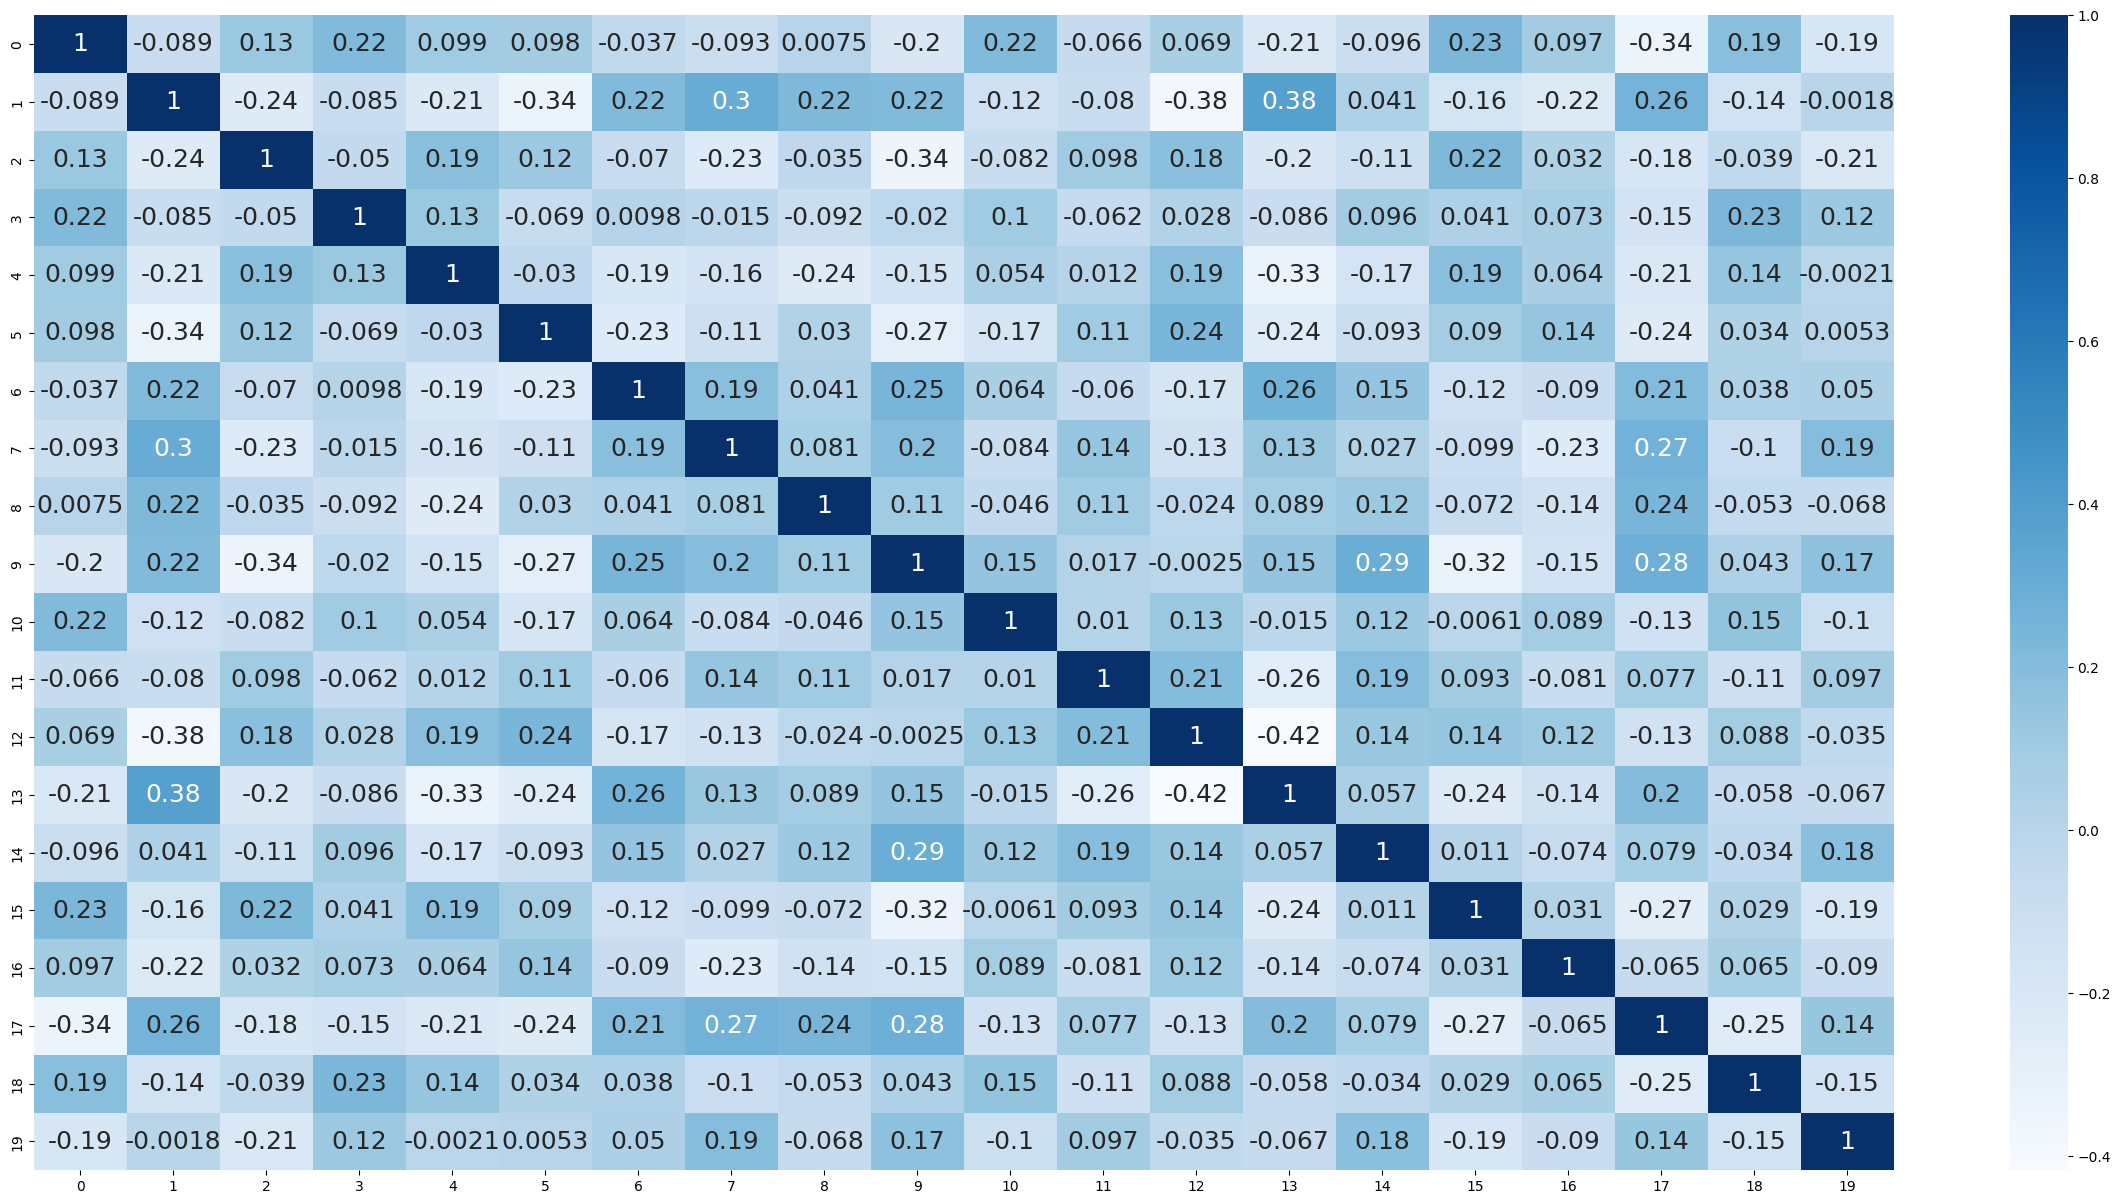

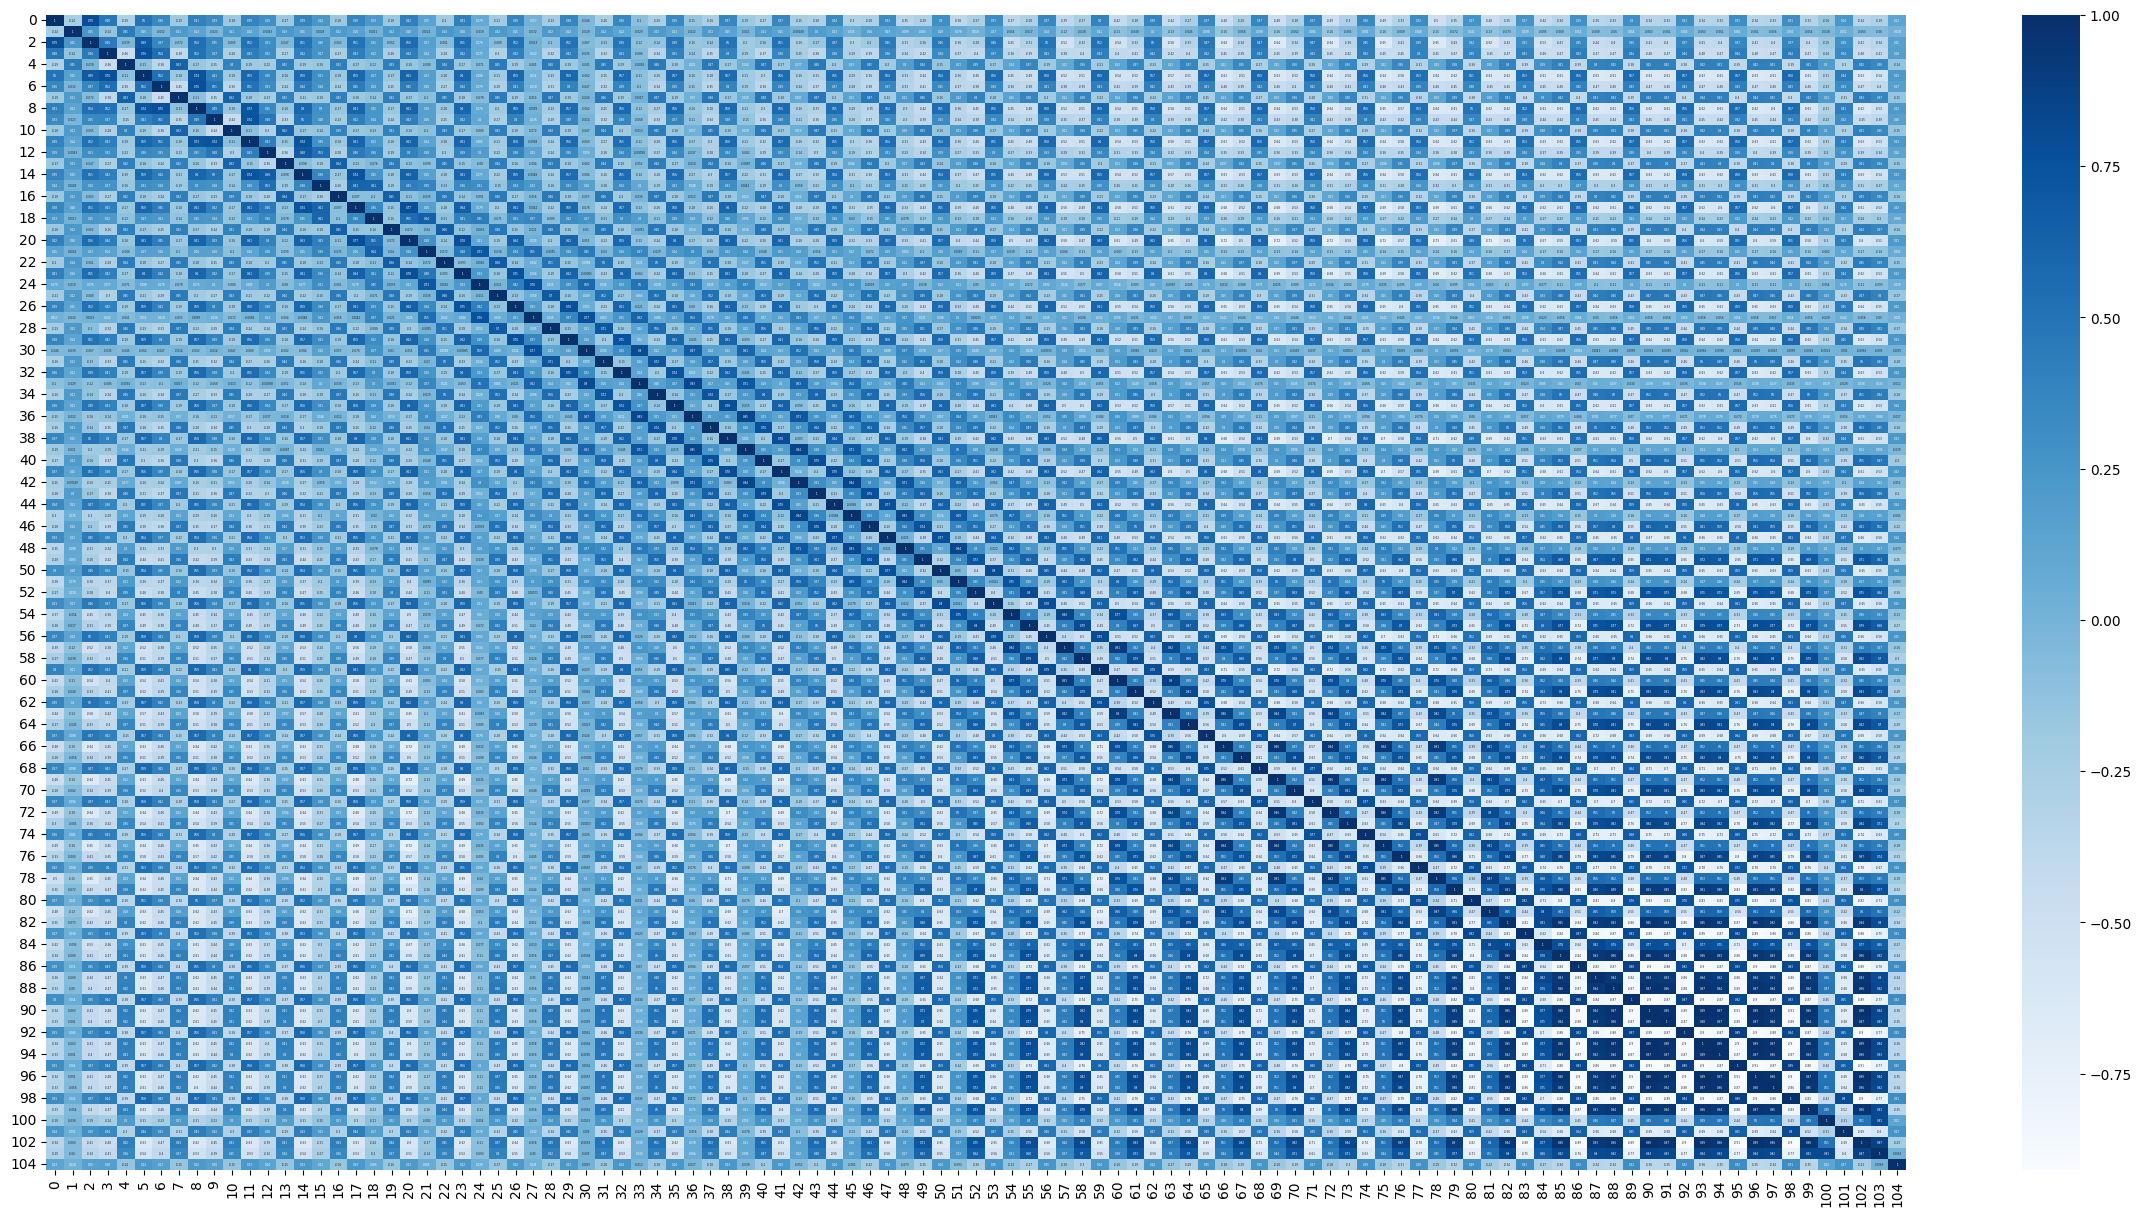

In [5]:
# Check for correlation
#d.corr() #less representative way
plt.figure(figsize=(30,15))
ax = sns.heatmap(embeddings_df[embeddings_df.columns[0:20]].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})
plt.figure(figsize=(30,15))
ax1 = sns.heatmap(embedded_domain_names_df[embedded_domain_names_df.columns].corr(),
                 cmap="Blues",annot=True,annot_kws={"size": 2})

In [5]:
#Lettura dati ed embedding

#random state per test con lo stesso split ogni volta
train, test, label_train, label_test=train_test_split(embeddings_df, dataset['label'], test_size=0.1, random_state=30)
print(train.shape)
print(test.shape)
print(label_train.shape)
print(label_test.shape)
#kfold = StratifiedKFold(n_splits=5) #cross-validation

(9000, 1024)
(1000, 1024)
(9000,)
(1000,)


In [6]:
# setting altri parametri per la classificazione
kfold = StratifiedKFold(n_splits=5)
cross_validation_scores = [] # punteggi della cross validation
classification_reports = []
confusion_matrices = []
roc_aucs = [] #roc curve:
true_pos_rates = []
false_pos_rates = []
#prep classificatori
names=["SVC", "KNN", "Naive Bayes", "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", "MLP"]
classifiers=[ SVC(), KNeighborsClassifier(n_neighbors=5), GaussianNB(), DecisionTreeClassifier(),
              RandomForestClassifier(n_estimators=10), AdaBoostClassifier(n_estimators=10), 
              GradientBoostingClassifier(n_estimators=10), MLPClassifier()]

"""
POSSIBILI PARAM DA GESTIRE SECONDO ME

SVC
Testare altri kernel? per ora default, rbf, ovvero esponenziale

KNN
default n_neighbors=5

ALBERO
criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
max_depth int, default=None
max_features int, float or {“auto”, “sqrt”, “log2”}, default=None
    (The number of features to consider when looking for the best split)
min_samples_split int or float, default=2
    (The minimum number of samples required to split an internal node)

Per avere sempre gli stessi risultati:
random_state int, RandomState instance or None, default=None 
    (The features are always randomly permuted at each split, even if splitter is set to "best")
    
RANDOM FOREST
n_estimators int, default=100
criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
max_depth int, default=None
max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”. Funzione del numero di feature.
    (The number of features to consider when looking for the best split)
min_samples_split int or float, default=2
    (The minimum number of samples required to split an internal node)
    
Per avere sempre gli stessi risultati uguale agli alberi

ADABOOST
default stimatori è 50
learning_rate: float, default=1.0

GRADIENT BOOSTING
default stimatori (alberi) è 100
learning rate default=0.1
parametri analoghi agli alberi

MLP
hidden_layer_sizes
solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’ (dicono che lbfgs tende ad essere meglio con dataset piccoli, non so
come conta il nostro)
batch_size:int, default=’auto’
"""
print(dict(zip(names,classifiers)).items())

dict_items([('SVC', SVC()), ('KNN', KNeighborsClassifier()), ('Naive Bayes', GaussianNB()), ('Decision Tree', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier(n_estimators=10)), ('AdaBoost', AdaBoostClassifier(n_estimators=10)), ('Gradient Boosting', GradientBoostingClassifier(n_estimators=10)), ('MLP', MLPClassifier())])


SVC. Accuracy: 0.938
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

KNN. Accuracy: 0.84
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

Naive Bayes. Accuracy: 0.84
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

Decision Tree. Accuracy: 0.792
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

Random Forest. Accuracy: 0.851
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

AdaBoost. Accuracy: 0.844
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

Gradient Boosting. Accuracy: 0.831
Done K-Fold cross-validation
Computed confusion matrix
Done classification report
computed ROC curve paramaters

MLP. Accuracy: 0.

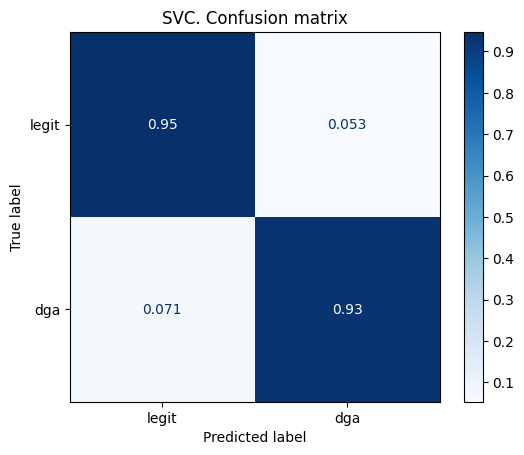

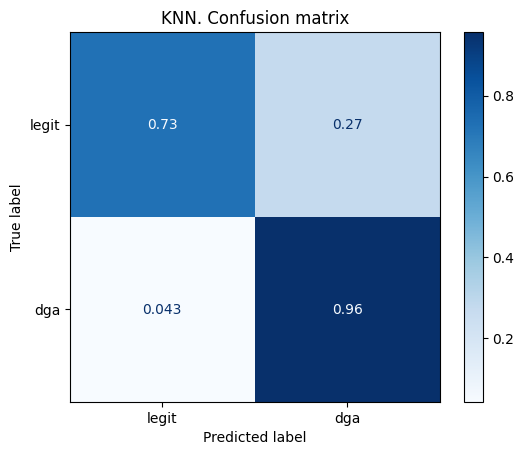

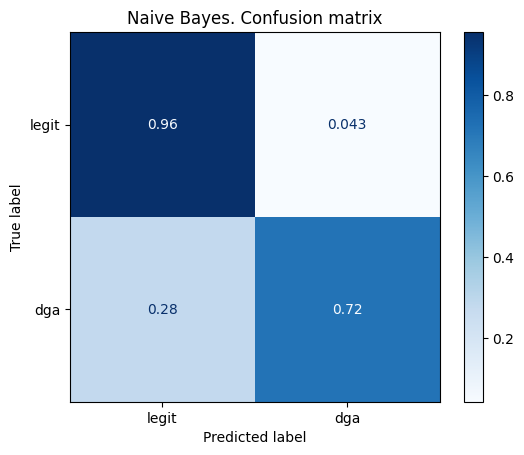

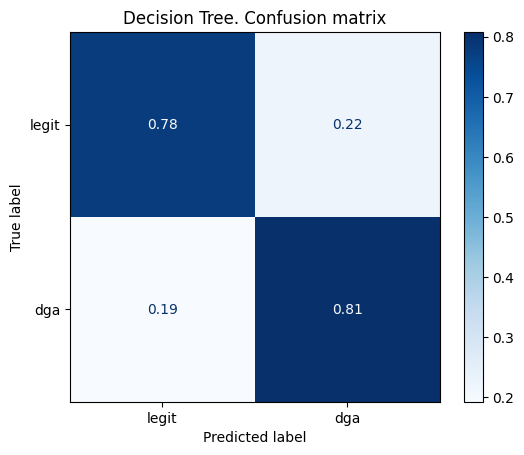

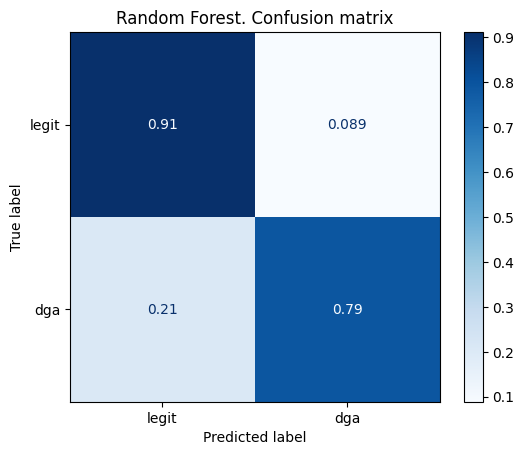

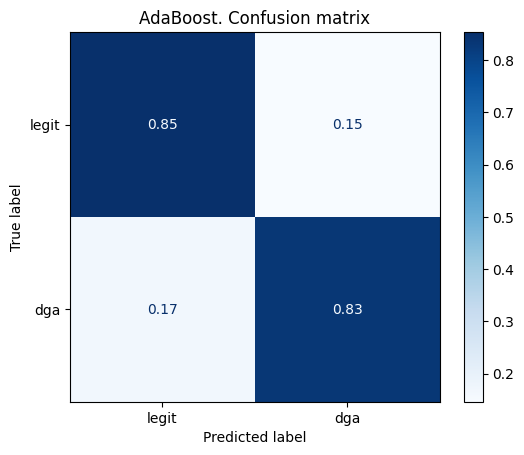

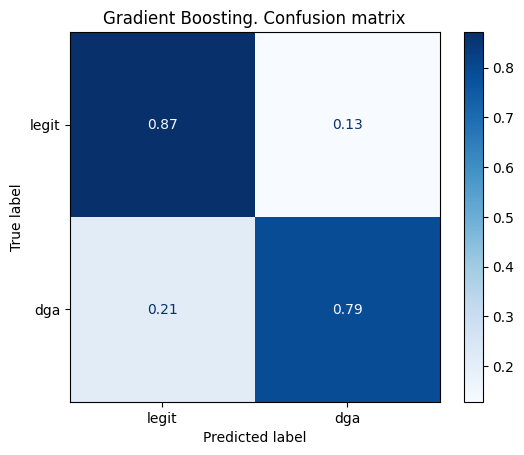

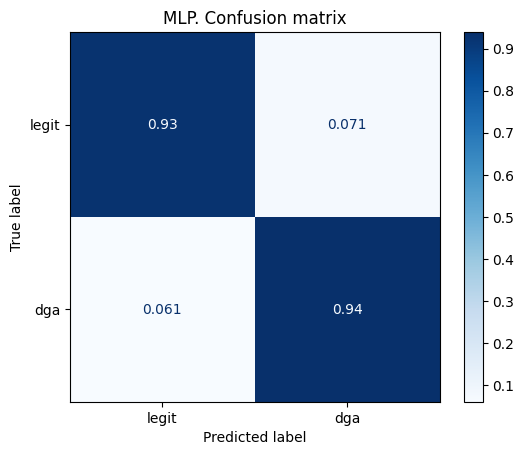

In [7]:
#train e test dei classificatori
for name, classif in zip(names,classifiers):
    # fitting model and make predictions
    classif.fit(train, label_train)
    predictions = classif.predict(test)
    print(f"{name}. Accuracy: {accuracy_score(label_test, predictions)}")
    # cross-validation
    cv_score = cross_val_score(classif, train, label_train, scoring = "accuracy",cv = kfold)
    cross_validation_scores.append(cv_score)
    print("Done K-Fold cross-validation")
    # confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        label_test, 
        predictions,
        display_labels=["legit", "dga"],
        cmap=plt.cm.Blues,
        normalize="true",
    )
    disp.ax_.set_title(f"{name}. Confusion matrix")
    confusion_matrices.append(disp)
    print("Computed confusion matrix")
    # classification report
    class_report = classification_report(label_test, predictions)
    classification_reports.append(class_report)
    print("Done classification report")
    # roc_curve
    fpr, tpr, _ = roc_curve(predictions, label_test)
    roc_aucs.append(auc(fpr, tpr))
    true_pos_rates.append(tpr)
    false_pos_rates.append(fpr)
    print("computed ROC curve paramaters")
    print()

   CrossValMeans  CrossValerrors          Algorithm
0       0.935889        0.004076                SVC
1       0.834667        0.004901                KNN
2       0.845222        0.004589        Naive Bayes
3       0.794778        0.008078      Decision Tree
4       0.853889        0.003928      Random Forest
5       0.846222        0.009002           AdaBoost
6       0.848778        0.011871  Gradient Boosting
7       0.931444        0.001144                MLP


Text(0.5, 1.0, 'Cross validation scores')

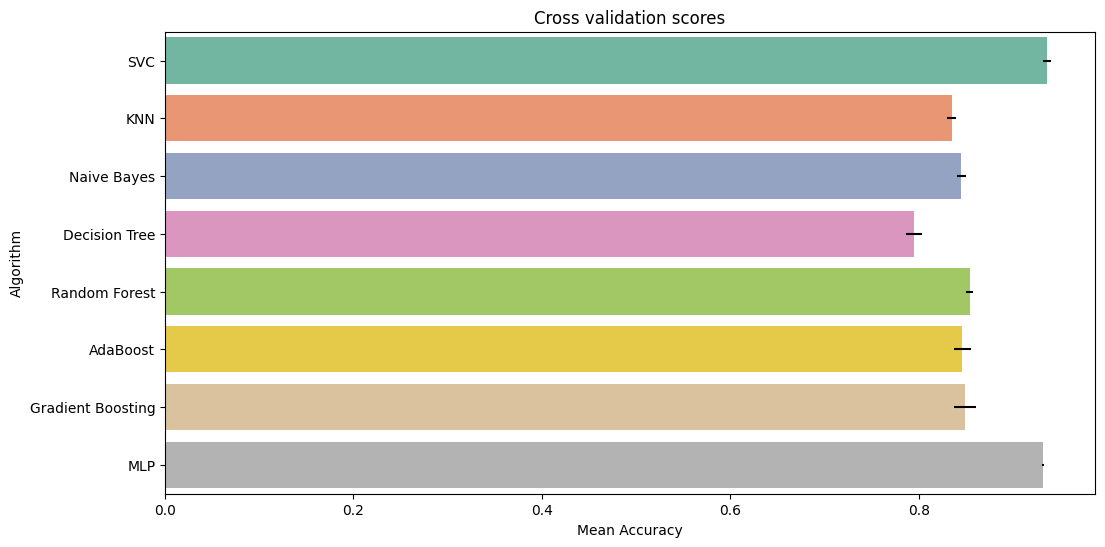

In [8]:
cross_val_mean_acc = [] # accuretezza media della cross validation
cross_val_std = [] # deviazione standard della cross validation
# cross validation plot
for i in cross_validation_scores:
    cross_val_mean_acc.append(i.mean())
    cross_val_std.append(i.std())
cv_df = pd.DataFrame({"CrossValMeans":cross_val_mean_acc, "CrossValerrors": cross_val_std,"Algorithm":names})
print(cv_df)
plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm", data=cv_df, palette="Set2",orient = "h", **{'xerr':cross_val_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

In [9]:
# confusion matrix display
for i in range(len(names)):
    print(confusion_matrices[i])
    plt.show()

In [10]:
#Classification reports
for i in range(len(names)):
    print (f"{names[i]} Classification Report:" );
    print (classification_reports[i]);

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       506
           1       0.94      0.93      0.94       494

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.82       506
           1       0.77      0.96      0.86       494

    accuracy                           0.84      1000
   macro avg       0.86      0.84      0.84      1000
weighted avg       0.86      0.84      0.84      1000

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       506
           1       0.94      0.72      0.82       494

    accuracy                           0.84      1000
   macro avg       0.86      0.84      

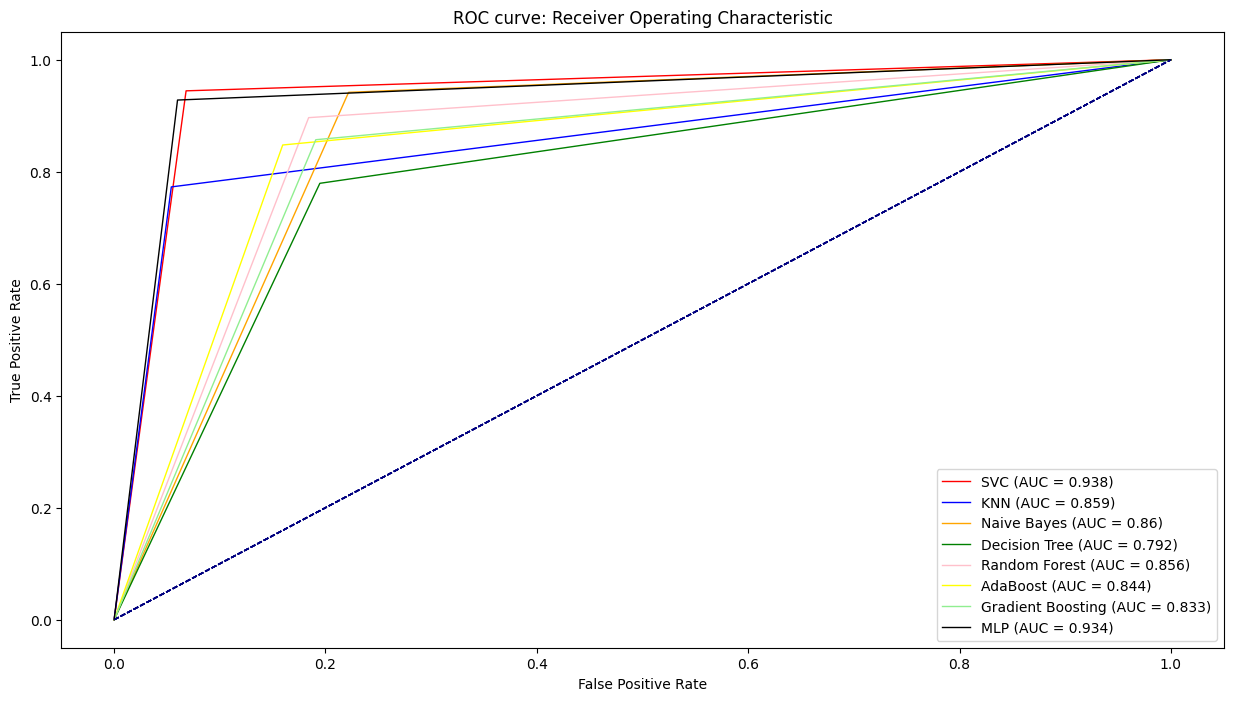

In [11]:
plt.figure(figsize=(15,8))
for i in range(len(names)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(false_pos_rates[i], true_pos_rates[i], c=cm[i], lw=1, 
             label=f"{names[i]} (AUC = {round(roc_aucs[i],3)})")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [15]:
#clustering
true_labels = list(dataset['label'])
#kmeans
#X = StandardScaler().fit_transform(X) serve?
kmeans=KMeans(n_clusters=2)
cluster=kmeans.fit(embedded_domain_names)
pred_labels=cluster.labels_
silhouette = silhouette_score(embedded_domain_names, true_labels, metric="euclidean")
homogeneity, completeness, v_measure= homogeneity_completeness_v_measure(true_labels, pred_labels)

print("Stats KMeans:")
print(f"Silhouette: {silhouette}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")
    

/home/lorenzo/PycharmProjects/datascienceETL/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Stats KMeans:
Silhouette: 0.16921581327915192
Homogeneity: 0.10955414446479993
Completeness: 0.23156510074520886
V-measure: 0.1487392860782644


In [23]:
#dbscan
dbscan=DBSCAN(eps=4, min_samples=156)
cluster=dbscan.fit(embedded_domain_names)
pred_labels=cluster.labels_
print(pred_labels)
print(set(pred_labels))
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
n_noise = list(pred_labels).count(-1)
silhouette = silhouette_score(embedded_domain_names, pred_labels, metric="euclidean")
homogeneity, completeness, v_measure= homogeneity_completeness_v_measure(true_labels, pred_labels)

print("Stats DBScan:")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Silhouette: {silhouette}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")
    

[ 0  0  0 ... -1 -1 -1]
{0, 1, -1}
Stats DBScan:
Number of clusters: 2
Number of noise points: 1149
Silhouette: 0.3969305157661438
Homogeneity: 0.21684094239624518
Completeness: 0.23069135773030625
V-measure: 0.22355182586268532
